In [1]:
import os
from pathlib2 import Path

import torch
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from src.data.dataloader import get_loaders_with_concepts
from src.models.utils import load_experiment
from src.models.test import test_model
from src.data.process_dataset import get_meta
from src.evaluation.gradcam import *

In [2]:
plt.style.use('ggplot')
sns.set(font_scale=1.0)
sns.set_style('darkgrid')

In [3]:
BASE_PATH               = Path("../..")
PROCESSED_DATA_PATH     = BASE_PATH / 'data/processed/CUB_processed'
RAW_DATA_PATH           = BASE_PATH / 'data/raw/CUB_200_2011'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
meta = get_meta(RAW_DATA_PATH / 'CUB_200_2011')

idx2label, label2idx = meta['classes'].values()

In [4]:
normalization = {'mean': np.array([0.5, 0.5, 0.5]), 'std': np.array([2.0, 2.0, 2.0])}
# Inverse normalization - reverts from normalized to original image space
invNormalization = transforms.Compose([
    transforms.Normalize(mean=[ 0., 0., 0. ], std=1 / normalization['std']), 
    transforms.Normalize(mean=-normalization['mean'], std = [1., 1., 1.]),
])

In [5]:
raw_datafolder_path = BASE_PATH / 'data/raw/CUB_200_2011'
processed_datafolder_path = BASE_PATH / 'data/processed/CUB_processed/class_attr_data_10'

loaders, normalization = get_loaders_with_concepts(
    raw_data_folder=raw_datafolder_path,
    processed_data_folder=processed_datafolder_path,
    batch_size=32,
)

INFO - Loading data...
INFO - training data loaded !
INFO - validation data loaded !
INFO - test data loaded !


In [6]:
experiment_checkpoint   = 'ResNet50-no_freeze-lr1e-4.wd1e-3.bz32.seed0/best.ckpt'

# Define experiment path
experiment_path = BASE_PATH / 'models' / experiment_checkpoint

# Load experiment stored from training
model_name, model, criterion = load_experiment(experiment_path, device=device)
model.eval()

print("")


INFO - LOADED EXPERIMENT: ResNet50-no_freeze-lr1e-4.wd1e-3.bz32.seed0
INFO -  model: {'name': 'ResNet50'}
INFO -  seed: 0
INFO -  best epoch: 24
INFO -  data: 
INFO -    filename: 
INFO -    normalization (mu, sigma): ([0.5, 0.5, 0.5], [2, 2, 2])




In [7]:
x_to_c_path = r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI\models\CBM_independent\independent_image_to_concept_best_model_1.pth"
c_to_y_path = r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI\models\CBM_independent\independent_concept_to_prediction_best_model_1.pth"

x_to_c = torch.load(x_to_c_path)
c_to_y = torch.load(c_to_y_path)

x_to_c.eval()
print(" ")

In [8]:
# Define GradCAM target layer
target_layers = [model.layer4[-1]]
# Define GradCAM model
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

### Predict on the full test set

In [9]:
# Run test
preds, _, _ = test_model(
    loaders=loaders,
    model=model, 
    criterion=criterion,
    device=device,
)

preds_ = preds.cpu().numpy()

import gc
del preds
gc.collect()

torch.cuda.empty_cache()

INFO - using device: cuda


Predicting on test set...: 100%|██████████| 182/182 [00:56<00:00,  3.24it/s]


--------------------------------------------------------------------------------
PERFORMANCE ON TEST SET
--------------------------------------------------------------------------------
Avg. accuracy (with SEM) =  0.76441 +- 0.00558
--------------------------------------------------------------------------------


In [10]:
from tqdm import tqdm
from torchmetrics.classification import MultilabelJaccardIndex

cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
jac = MultilabelJaccardIndex(num_labels=112, average="weighted")
jac.cuda()

outputs_all = []

for images, labels, concepts in tqdm(loaders['test']):
    image_b = images.cuda(non_blocking=True)
    label = labels.cuda(non_blocking=True)
    concepts = torch.stack(concepts,dim=1).cuda(non_blocking=True)

    with torch.no_grad():
        outputs = x_to_c(image_b)
    
    outputs = torch.squeeze(torch.stack(outputs,dim=1))
    outputs = torch.nn.functional.sigmoid(outputs)
    
    outputs_all.append(outputs)

outputs_all = torch.cat(outputs_all)


outputs_all_ = outputs_all.cpu().numpy()

import gc
del outputs_all
gc.collect()

torch.cuda.empty_cache()

  0%|          | 0/182 [00:00<?, ?it/s]c:\Users\alber\Miniconda3\envs\xai_project\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 182/182 [00:33<00:00,  5.44it/s]


### Visualize approach (permutation-based)

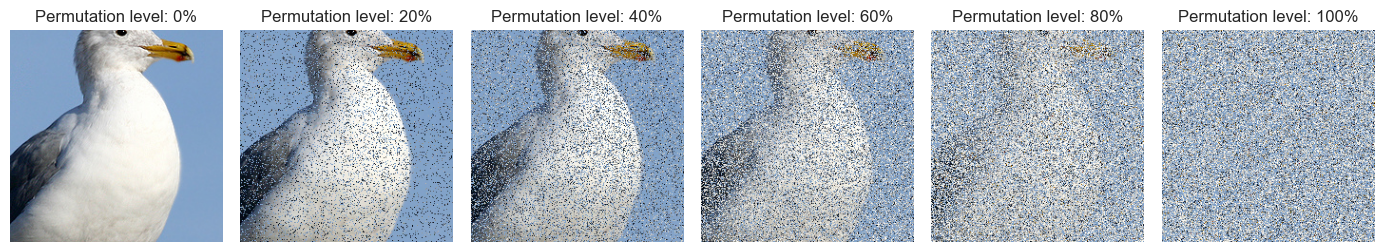

In [14]:
# Select image index to visualize
np.random.seed(0)
# selected_idxs = np.random.choice(len(loaders['test'].dataset), 10, replace=False)
selected_idxs = [1840]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(14, 5))
for i, frac in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)


    # Get original and target image
    original_image  = batch['image'][0].numpy()
    target_image    = original_image.copy()

    # Do pixel flipping
    for pixel in range(sample_size):
        target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
    target_image = torch.tensor(target_image)
    
    axs[i].imshow(invNormalization(target_image).permute(1,2,0).numpy())
    axs[i].axis('off')
    axs[i].set_title(f'Permutation level: {frac * 100:.0f}%')

# fig.suptitle('Pixel Flipping')
plt.tight_layout()
plt.show()

### Run experiment on trained models

In [26]:
from tqdm.notebook import tqdm
from skimage.metrics import structural_similarity as ssim
from collections import defaultdict


# pixel_flip_ratios = np.linspace(0, 1, 51)
pixel_flip_ratios = np.concatenate([np.linspace(0, 0.2, 11), np.linspace(0.2, 0.5, 7)[1:], np.linspace(0.5, 1.0, 6)[1:]])

np.random.seed(0)

# Compute saliency maps
CAM_target = 'prediction'

height, width   = 224, 224
N_pixels        = height * width

pearson_saliency_coefs, ssim_saliency_coefs = defaultdict(list), defaultdict(list)
pearson_image_coefs, ssim_image_coefs = defaultdict(list), defaultdict(list)
jaccard_concept_coefs, cos_concept_coefs, pearson_concept_coefs = defaultdict(list), defaultdict(list), defaultdict(list)

# Testing loop
BZ = 32
N_testing_points = 32 * 80
available_idxs = np.arange(len(preds_))

outputs_all_ = torch.tensor(outputs_all_).cuda()
concept_preds = (outputs_all_ > 0.5).to(int) # Rasmus predictions of concepts

for idx in tqdm(range(N_testing_points // 32), desc='Predicting on test set...'):
# for idx in tqdm(range(preds_.__len__() // 32), desc='Predicting on test set...'):    
    # selected_idxs = np.arange(idx*BZ, (idx+1)*BZ)
    
    selected_idxs = np.random.choice(available_idxs, BZ)
    available_idxs = np.setdiff1d(available_idxs, selected_idxs)

    batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)    
    saliency_maps = compute_saliency_maps(batch, cam=cam, CAM_target=CAM_target)

    for i, frac in tqdm(enumerate(pixel_flip_ratios), desc='Running pixel-flipping loop...', total=len(pixel_flip_ratios)):
        sample_size = int(np.ceil(frac * N_pixels))

        # Create origin and target pixel lists
        original_pixel  = np.arange(height * width)
        target_pixel    = np.random.permutation(original_pixel)

        # Setup storage
        batch_ = {'index': batch['index'], 'image': [], 'label': batch['label'], 'prediction': [], 'concepts': batch['concepts']}
        for image_idx in range(batch['index'].__len__()):
            
            # Get original and target image
            original_image  = batch['image'][image_idx].numpy()
            target_image    = original_image.copy()

            # Do pixel flipping
            for pixel in range(sample_size):
                target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
            
            # Define target image as tensor
            target_image = torch.tensor(target_image)
            output = model(target_image.unsqueeze(0).to(device))

            pearson_image_coefs[frac].append(np.corrcoef(original_image.flatten(), target_image.flatten())[0, 1])
            ssim_image_coefs[frac].append(ssim(original_image.flatten(), target_image.numpy().flatten(), data_range=1))

            # Update batch_ and prediction before computing saliency map 
            batch_['image'].append(target_image)
            batch_['prediction'].append(torch.exp(output).topk(1)[1].cpu())


        # Compute permuted saliency maps
        batch_['image'] = torch.stack(batch_['image'])
        permuted_saliency_maps = compute_saliency_maps(batch_, cam=cam, CAM_target=CAM_target)
        

        # COMPUTE FOR CONCEPT PREDICTIONS!
        with torch.no_grad():
            outputs_cbm = x_to_c(batch_['image'].cuda(non_blocking=True))

        outputs_cbm = torch.squeeze(torch.stack(outputs_cbm, dim=1))
        outputs_cbm = torch.nn.functional.sigmoid(outputs_cbm)

        batch_concept_preds = concept_preds[selected_idxs].cuda()
        permuted_concept_preds = (outputs_cbm > 0.5).to(torch.int).cuda()
        
        for i in range(BZ):
            jaccard_concept_coefs[frac].append(jac(outputs_cbm[i].unsqueeze(0), batch_concept_preds[i].unsqueeze(0)).item())
            # jaccard_concept_coefs[frac].append(np.round(jac(permuted_concept_preds[i].unsqueeze(0), batch_concept_preds[i].unsqueeze(0)).item(), 4))
            pearson_concept_coefs[frac].append(np.corrcoef(batch_concept_preds[i].cpu().flatten(), permuted_concept_preds[i].cpu().flatten())[0, 1])

        # cos_concept_coefs[frac].append(cos(batch_concept_preds.to(float), permuted_concept_preds.to(float)).cpu().numpy())
        cos_concept_coefs[frac].append(cos(outputs_cbm, outputs_all_[selected_idxs]).cpu().numpy())

        # Get similarity scores to original saliency map
        for map_idx, sm_orig in saliency_maps.items():
            sm_permuted = permuted_saliency_maps[map_idx]

            sm_orig = (sm_orig - sm_orig.min()) / (sm_orig.max() - sm_orig.min())
            sm_permuted = (sm_permuted - sm_permuted.min()) / (sm_permuted.max() - sm_permuted.min())

            pearson_saliency_coefs[frac].append(np.corrcoef(sm_orig.flatten(), sm_permuted.flatten())[0, 1])
            ssim_saliency_coefs[frac].append(ssim(sm_orig, sm_permuted, data_range=1))

C:\Users\alber\AppData\Local\Temp\ipykernel_20192\1248642711.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs_all_ = torch.tensor(outputs_all_).cuda()


Predicting on test set...:   0%|          | 0/80 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

c:\Users\alber\Miniconda3\envs\xai_project\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

Running pixel-flipping loop...:   0%|          | 0/22 [00:00<?, ?it/s]

In [52]:
save_path = r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI\data\robustness_score"

torch.save(ssim_saliency_coefs, f"{save_path}/ssim_saliency_coefs.pth")
torch.save(pearson_saliency_coefs, f"{save_path}/pearson_saliency_coefs.pth")
torch.save(ssim_image_coefs, f"{save_path}/ssim_image_coefs.pth")
torch.save(pearson_image_coefs, f"{save_path}/pearson_image_coefs.pth")
torch.save(jaccard_concept_coefs, f"{save_path}/jaccard_concept_coefs.pth")
torch.save(cos_concept_coefs, f"{save_path}/cos_concept_coefs.pth")
torch.save(pearson_concept_coefs, f"{save_path}/pearson_concept_coefs.pth")

In [30]:
import pandas as pd

### SALIENCY ### 
permutation_level, ssim_score, ssim_sem = list(zip(*[(k, np.mean(v), np.std(v) / np.sqrt(len(v))) for k, v in ssim_saliency_coefs.items()]))
_, pearson_score, pearson_sem = list(zip(*[(k, np.mean(v), np.std(v) / np.sqrt(len(v))) for k, v in pearson_saliency_coefs.items()]))

results_saliency = pd.DataFrame({
    'permutation_level': permutation_level, 
    'ssim': ssim_score, 'ssim_sem': ssim_sem, 
    'pearson': pearson_score, 'pearson_sem': pearson_sem
})

### IMAGES ###
permutation_level, ssim_score, ssim_sem = list(zip(*[(k, np.mean(v), np.std(v) / np.sqrt(len(v))) for k, v in ssim_image_coefs.items()]))
_, pearson_score, pearson_sem = list(zip(*[(k, np.mean(v), np.std(v) / np.sqrt(len(v))) for k, v in pearson_image_coefs.items()]))

results_images = pd.DataFrame({
    'permutation_level': permutation_level, 
    'ssim': ssim_score, 'ssim_sem': ssim_sem, 
    'pearson': pearson_score, 'pearson_sem': pearson_sem
})

### CONCEPTS ###
permutation_level, jaccard_score, jaccard_sem = list(zip(*[(k, np.mean(v), np.std(v) / np.sqrt(len(v))) for k, v in jaccard_concept_coefs.items()]))
_, cos_score, cos_sem = list(zip(*[(k, np.mean(v), np.std(v) / np.sqrt(len(v))) for k, v in cos_concept_coefs.items()]))
_, pearson_score, pearson_sem = list(zip(*[(k, np.mean(v), np.std(v) / np.sqrt(len(v))) for k, v in pearson_concept_coefs.items()]))

results_concepts = pd.DataFrame({
    'permutation_level': permutation_level, 
    'jaccard': jaccard_score, 'jaccard_sem': jaccard_sem, 
    'cos': cos_score, 'cos_sem': cos_sem,
    'pearson': cos_score, 'pearson_sem': cos_sem
})

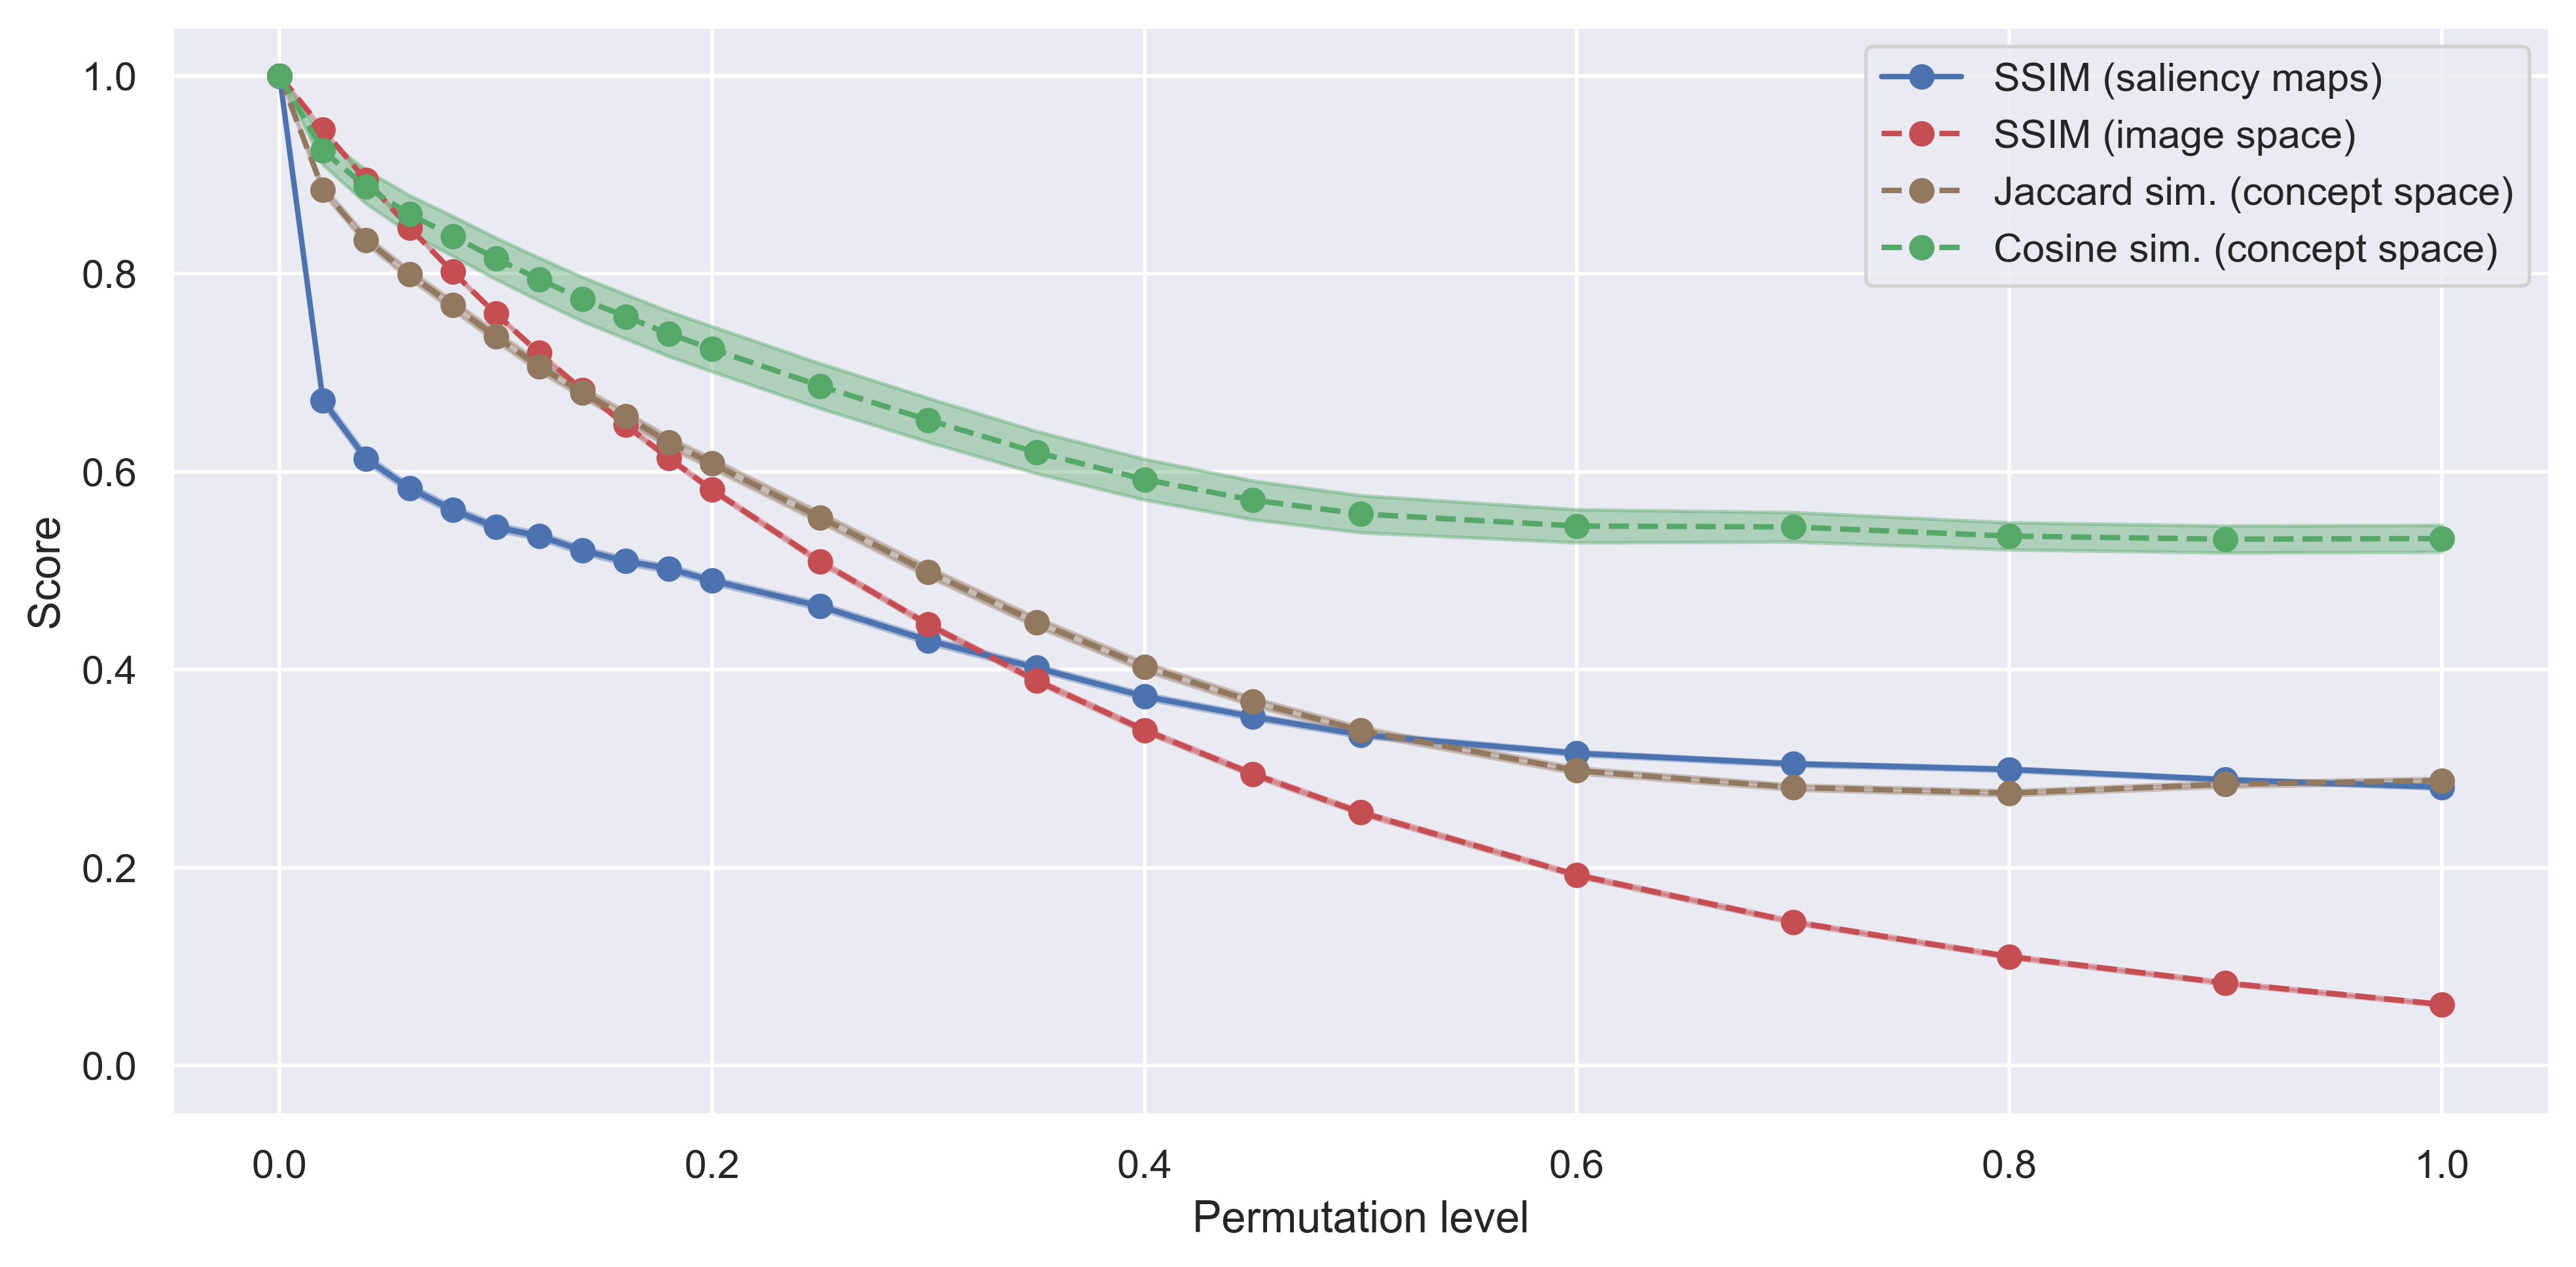

In [42]:
fig = plt.figure(figsize=(10, 5), dpi=400)

# Plot SSIM
plt.fill_between(results_saliency['permutation_level'], results_saliency['ssim'] - results_saliency['ssim_sem'], results_saliency['ssim'] + results_saliency['ssim_sem'], color='C0', alpha=0.4)
plt.plot(results_saliency['permutation_level'], results_saliency['ssim'], 'o-', color='C0', label='SSIM (saliency maps)')
# Plot ssim images
plt.fill_between(results_images['permutation_level'], results_images['ssim'] - results_images['ssim_sem'], results_images['ssim'] + results_images['ssim_sem'], color='C3', alpha=0.4)
plt.plot(results_images['permutation_level'], results_images['ssim'], 'o--', color='C3', label='SSIM (image space)')
# Plot concept Jaccard
plt.fill_between(results_concepts['permutation_level'], results_concepts['jaccard'] - results_concepts['jaccard_sem'], results_concepts['jaccard'] + results_concepts['jaccard_sem'], color='C5', alpha=0.4)
plt.plot(results_concepts['permutation_level'], results_concepts['jaccard'], 'o--', color='C5', label='Jaccard sim. (concept space)')
# Plot concept cosine
plt.fill_between(results_concepts['permutation_level'], results_concepts['cos'] - results_concepts['cos_sem'], results_concepts['cos'] + results_concepts['cos_sem'], color='C2', alpha=0.4)
plt.plot(results_concepts['permutation_level'], results_concepts['cos'], 'o--', color='C2', label='Cosine sim. (concept space)')

plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.ylabel('Score')
plt.xlabel('Permutation level')
plt.legend()
# fig.suptitle("Robustness - Pixel-Flipping")
plt.tight_layout()

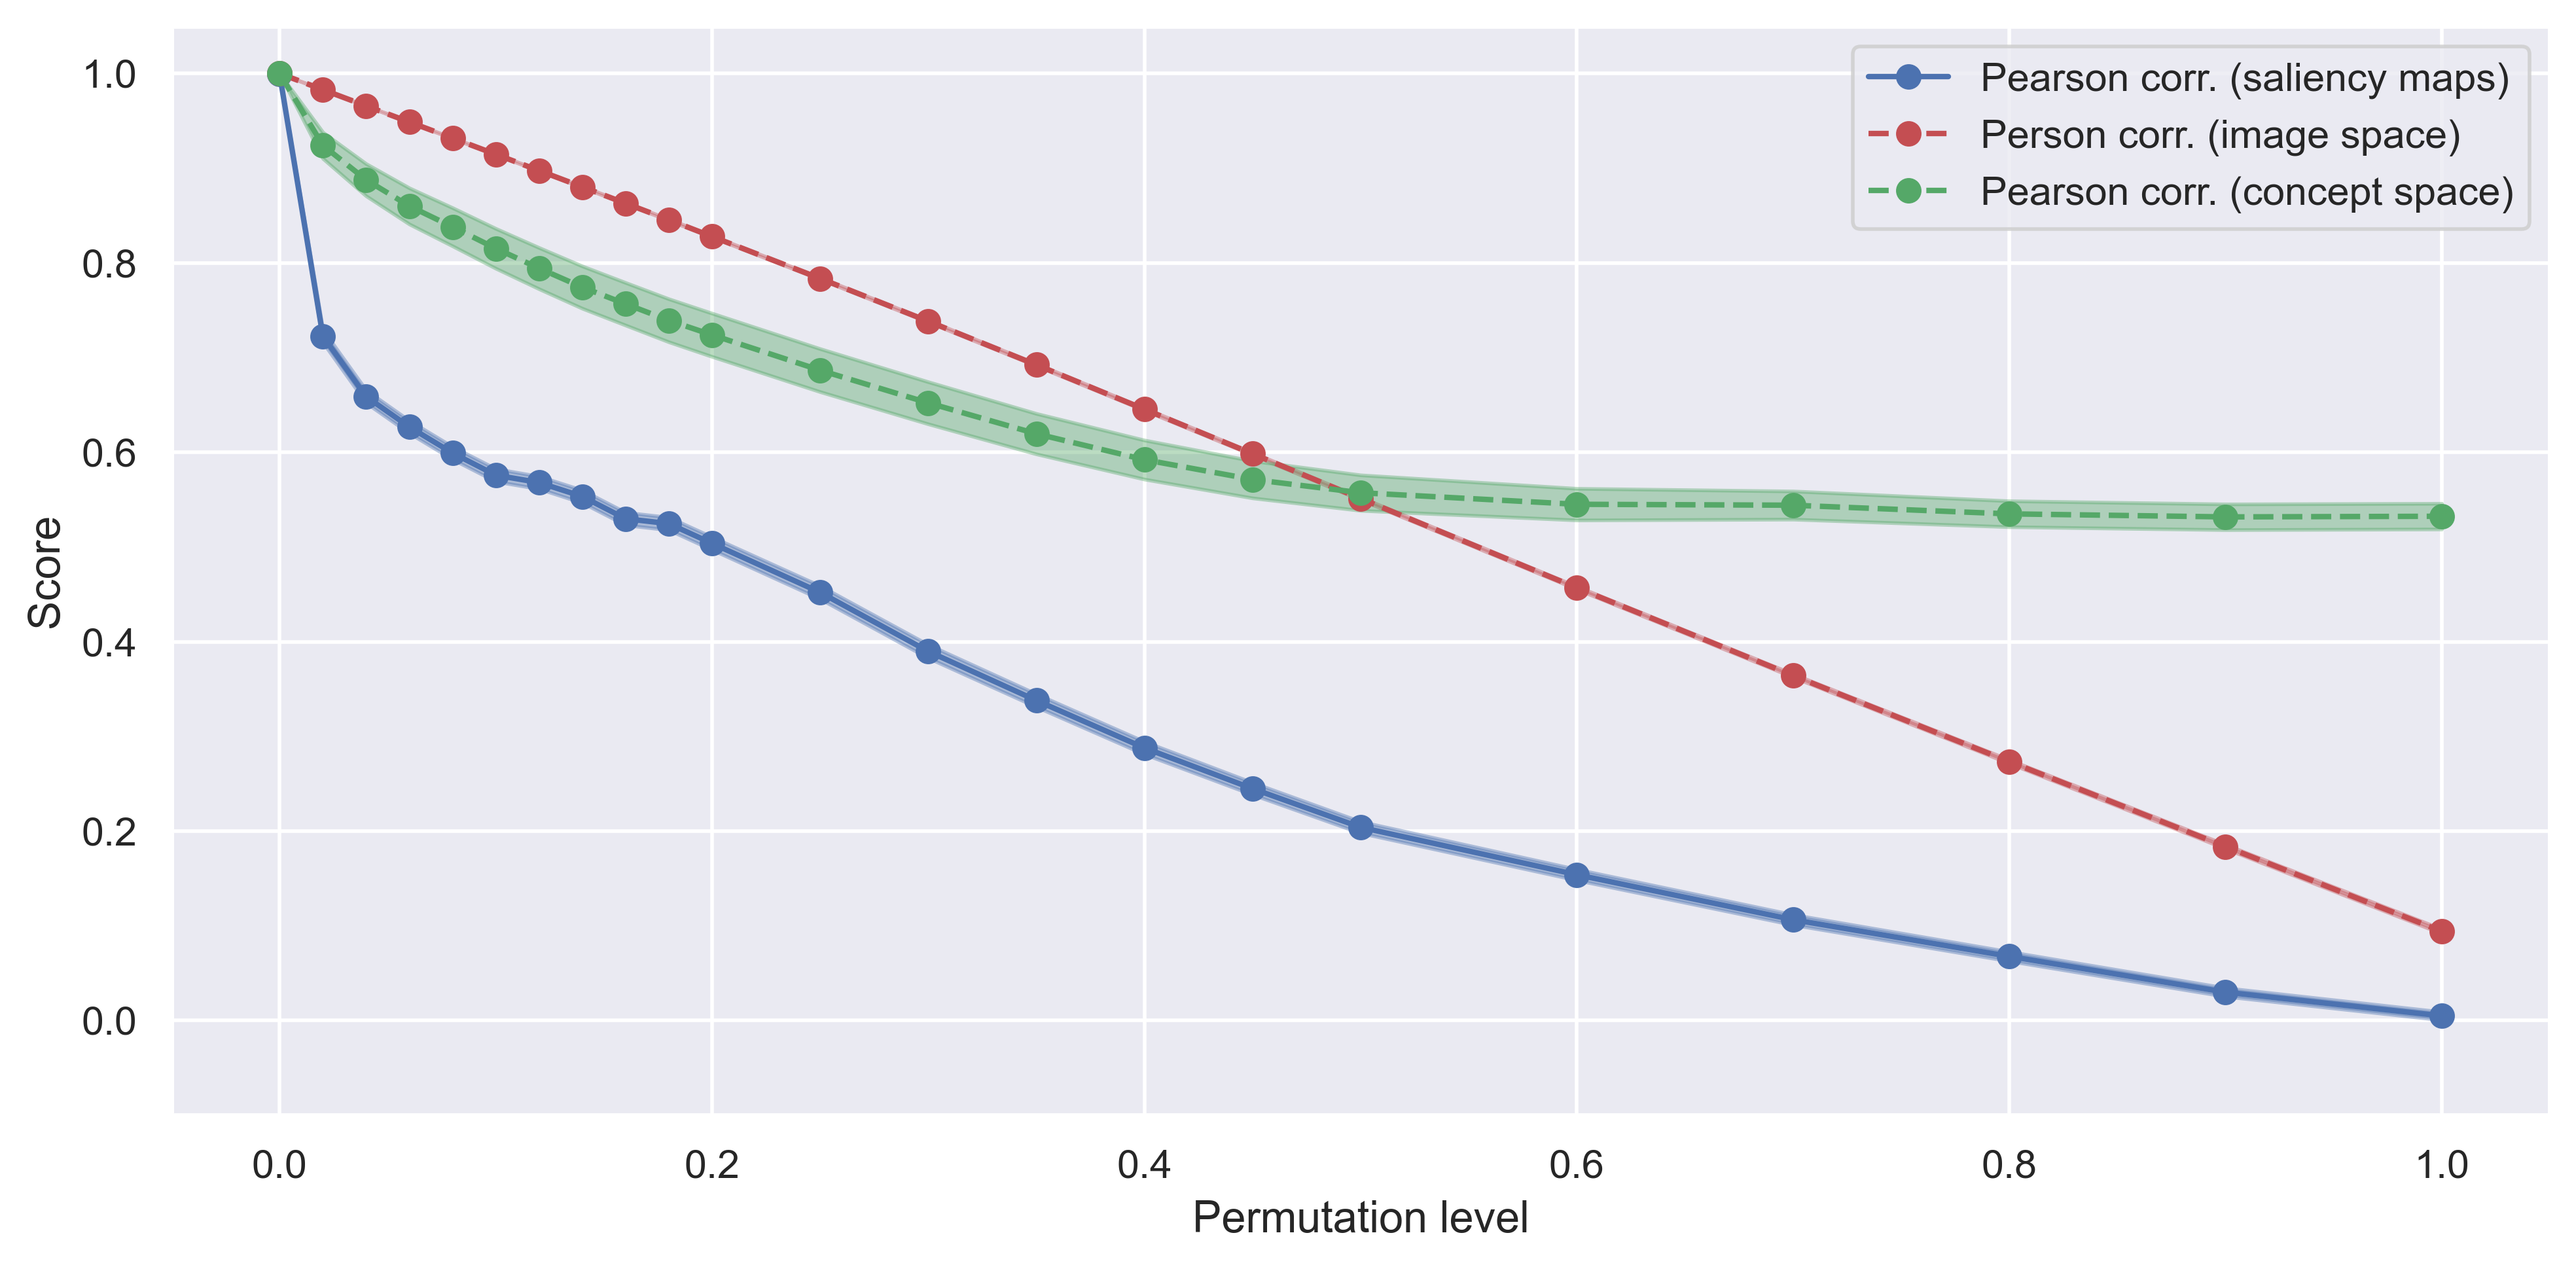

In [45]:
fig = plt.figure(figsize=(10, 5), dpi=400)

# Plot SSIM
plt.fill_between(results_saliency['permutation_level'], results_saliency['pearson'] - results_saliency['pearson_sem'], results_saliency['pearson'] + results_saliency['pearson_sem'], color='C0', alpha=0.4)
plt.plot(results_saliency['permutation_level'], results_saliency['pearson'], 'o-', color='C0', label='Pearson corr. (saliency maps)')
# Plot ssim images
plt.fill_between(results_images['permutation_level'], results_images['pearson'] - results_images['pearson_sem'], results_images['pearson'] + results_images['pearson_sem'], color='C3', alpha=0.4)
plt.plot(results_images['permutation_level'], results_images['pearson'], 'o--', color='C3', label='Person corr. (image space)')
# Plot concept Jaccard
plt.fill_between(results_concepts['permutation_level'], results_concepts['pearson'] - results_concepts['pearson_sem'], results_concepts['pearson'] + results_concepts['pearson_sem'], color='C2', alpha=0.4)
plt.plot(results_concepts['permutation_level'], results_concepts['pearson'], 'o--', color='C2', label='Pearson corr. (concept space)')

plt.ylim([-0.1, 1.05])
plt.xlim([-0.05, 1.05])
plt.ylabel('Score')
plt.xlabel('Permutation level')
plt.legend()
# fig.suptitle("Robustness - Pixel-Flipping")
plt.tight_layout()

In [33]:
results_saliency['normalized_ssim'] = results_saliency.ssim.apply(lambda x: (x - results_saliency['ssim'].iloc[-1]) / (1 - results_saliency['ssim'].iloc[-1])) 
results_images['normalized_ssim'] = results_images.ssim.apply(lambda x: (x - results_images['ssim'].iloc[-1]) / (1 - results_images['ssim'].iloc[-1])) 
results_concepts['normalized_jaccard'] = results_concepts.jaccard.apply(lambda x: (x - results_concepts['jaccard'].iloc[-1]) / (1 - results_concepts['jaccard'].iloc[-1])) 
results_concepts['normalized_cos'] = results_concepts.cos.apply(lambda x: (x - results_concepts['cos'].iloc[-1]) / (1 - results_concepts['cos'].iloc[-1])) 

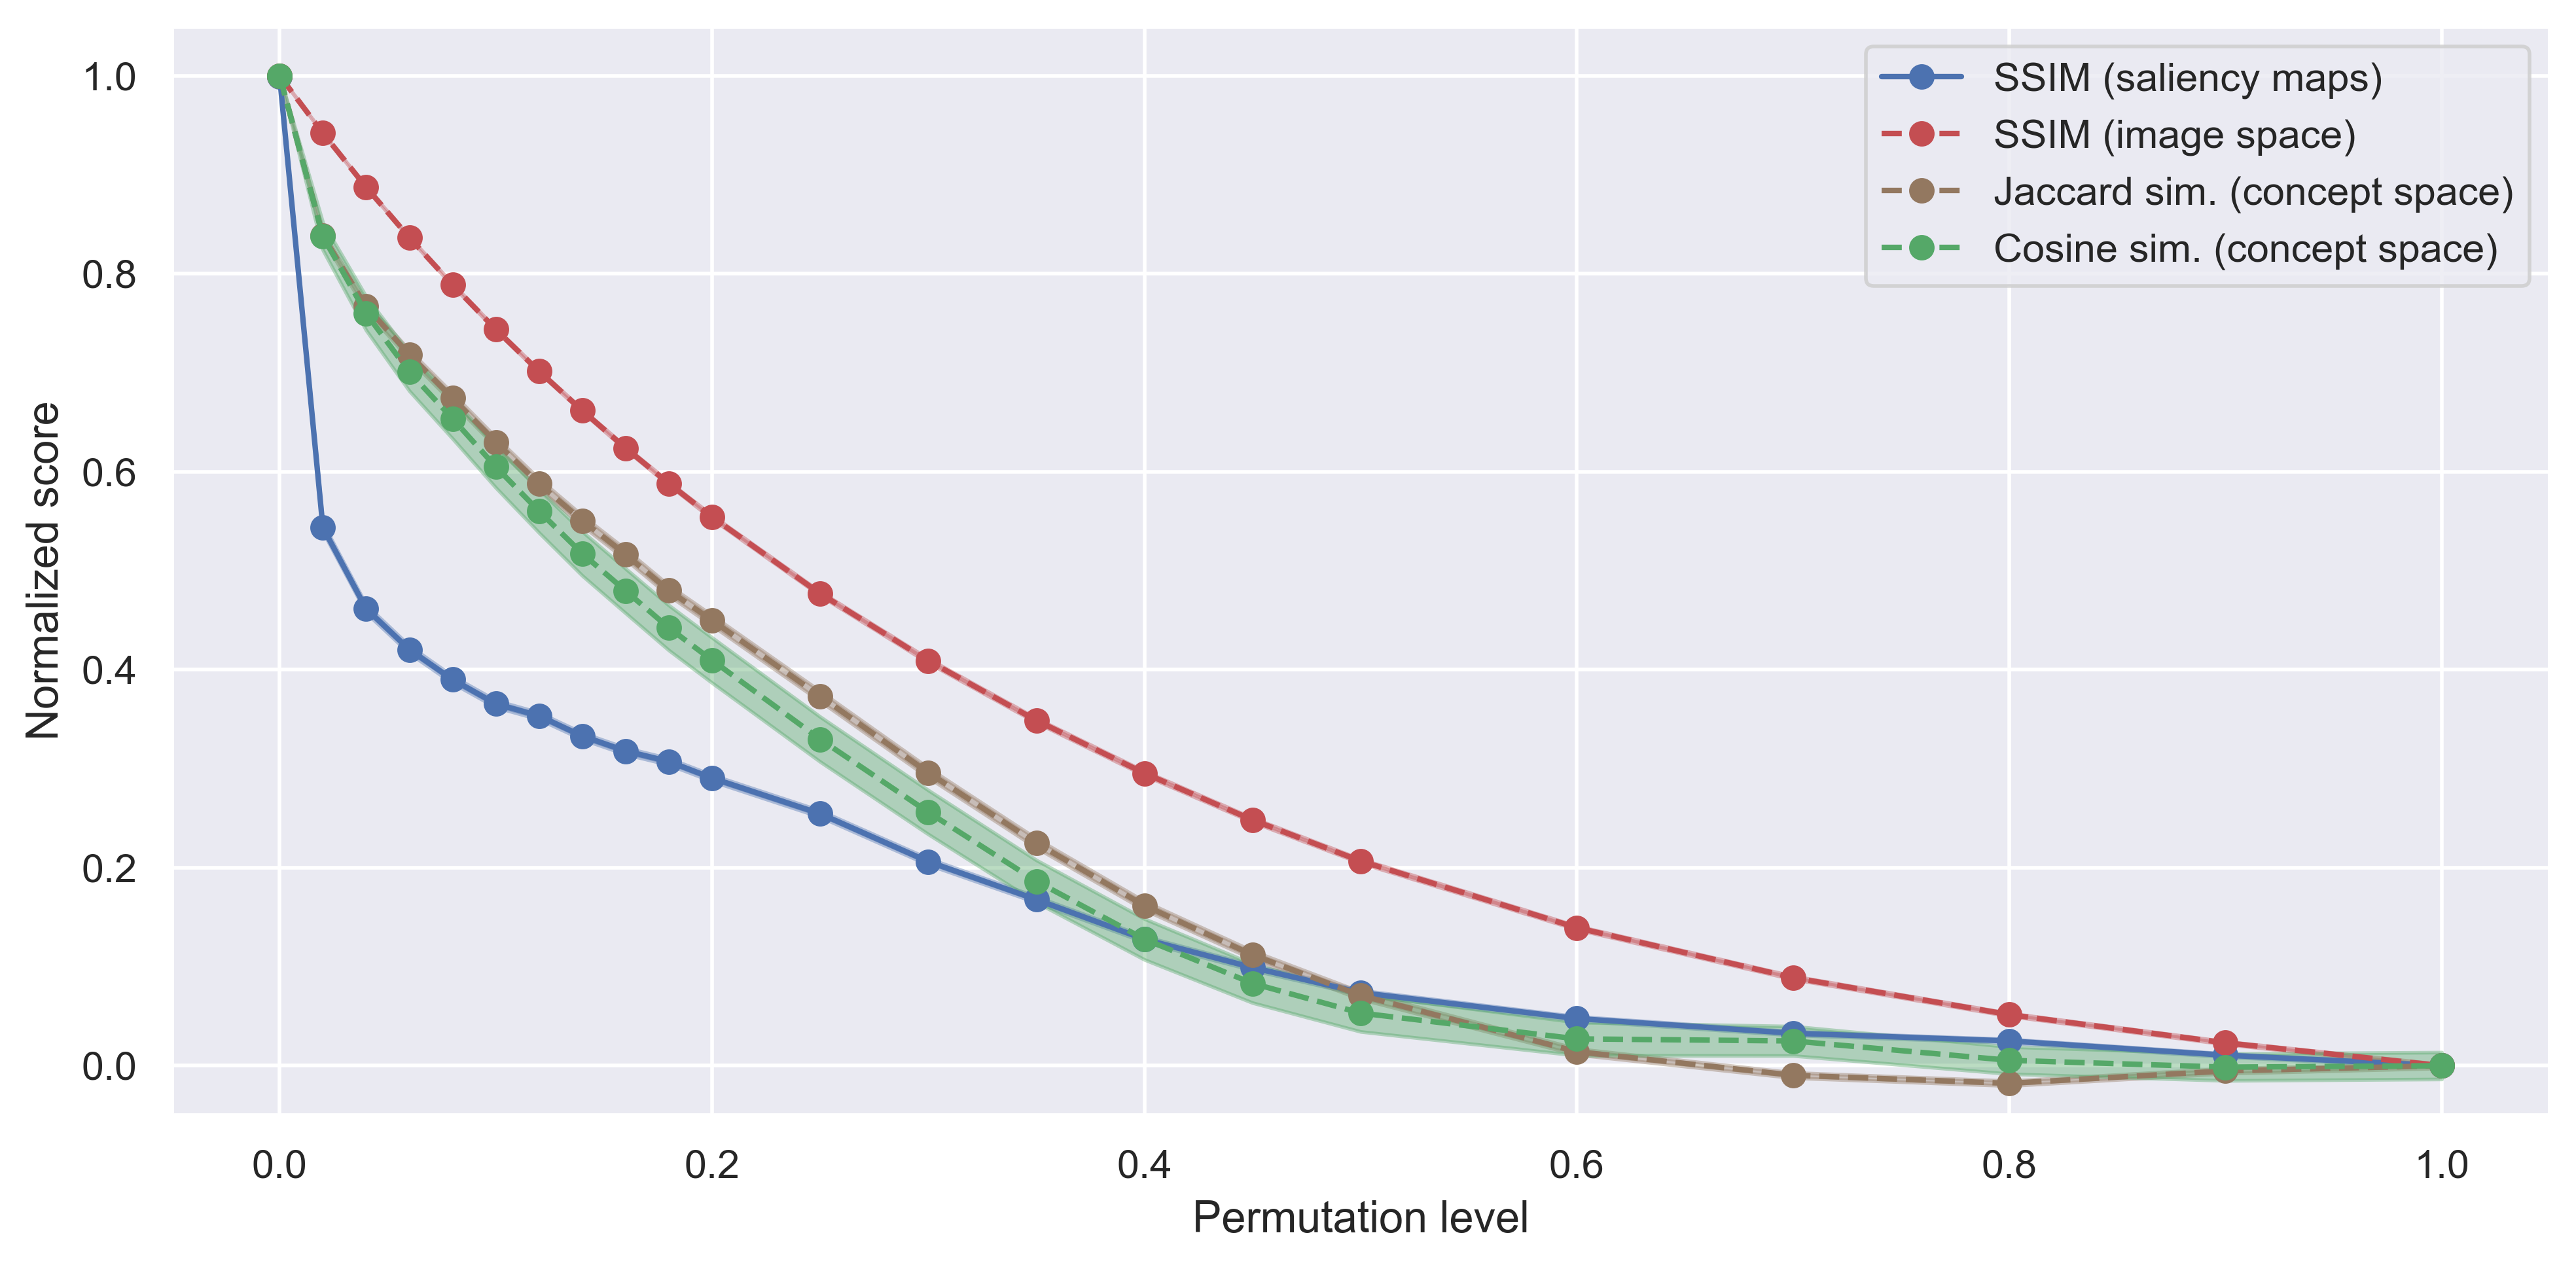

In [40]:
fig = plt.figure(figsize=(10, 5), dpi=400)

# Plot SSIM
plt.fill_between(results_saliency['permutation_level'], results_saliency['normalized_ssim'] - results_saliency['ssim_sem'], results_saliency['normalized_ssim'] + results_saliency['ssim_sem'], color='C0', alpha=0.4)
plt.plot(results_saliency['permutation_level'], results_saliency['normalized_ssim'], 'o-', color='C0', label='SSIM (saliency maps)')
# Plot ssim images
plt.fill_between(results_images['permutation_level'], results_images['normalized_ssim'] - results_images['ssim_sem'], results_images['normalized_ssim'] + results_images['ssim_sem'], color='C3', alpha=0.4)
plt.plot(results_images['permutation_level'], results_images['normalized_ssim'], 'o--', color='C3', label='SSIM (image space)')
# Plot concept Jaccard
plt.fill_between(results_concepts['permutation_level'], results_concepts['normalized_jaccard'] - results_concepts['jaccard_sem'], results_concepts['normalized_jaccard'] + results_concepts['jaccard_sem'], color='C5', alpha=0.4)
plt.plot(results_concepts['permutation_level'], results_concepts['normalized_jaccard'], 'o--', color='C5', label='Jaccard sim. (concept space)')
# Plot concept cosine
plt.fill_between(results_concepts['permutation_level'], results_concepts['normalized_cos'] - results_concepts['cos_sem'], results_concepts['normalized_cos'] + results_concepts['cos_sem'], color='C2', alpha=0.4)
plt.plot(results_concepts['permutation_level'], results_concepts['normalized_cos'], 'o--', color='C2', label='Cosine sim. (concept space)')

plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.ylabel('Normalized score')
plt.xlabel('Permutation level')
plt.legend()
# fig.suptitle("Robustness - Pixel-Flipping")
plt.tight_layout()

In [35]:
results_saliency['normalized_pearson'] = results_saliency.pearson.apply(lambda x: (x - results_saliency['pearson'].iloc[-1]) / (1 - results_saliency['pearson'].iloc[-1])) 
results_images['normalized_pearson'] = results_images.pearson.apply(lambda x: (x - results_images['pearson'].iloc[-1]) / (1 - results_images['pearson'].iloc[-1])) 
results_concepts['normalized_pearson'] = results_concepts.pearson.apply(lambda x: (x - results_concepts['pearson'].iloc[-1]) / (1 - results_concepts['pearson'].iloc[-1])) 

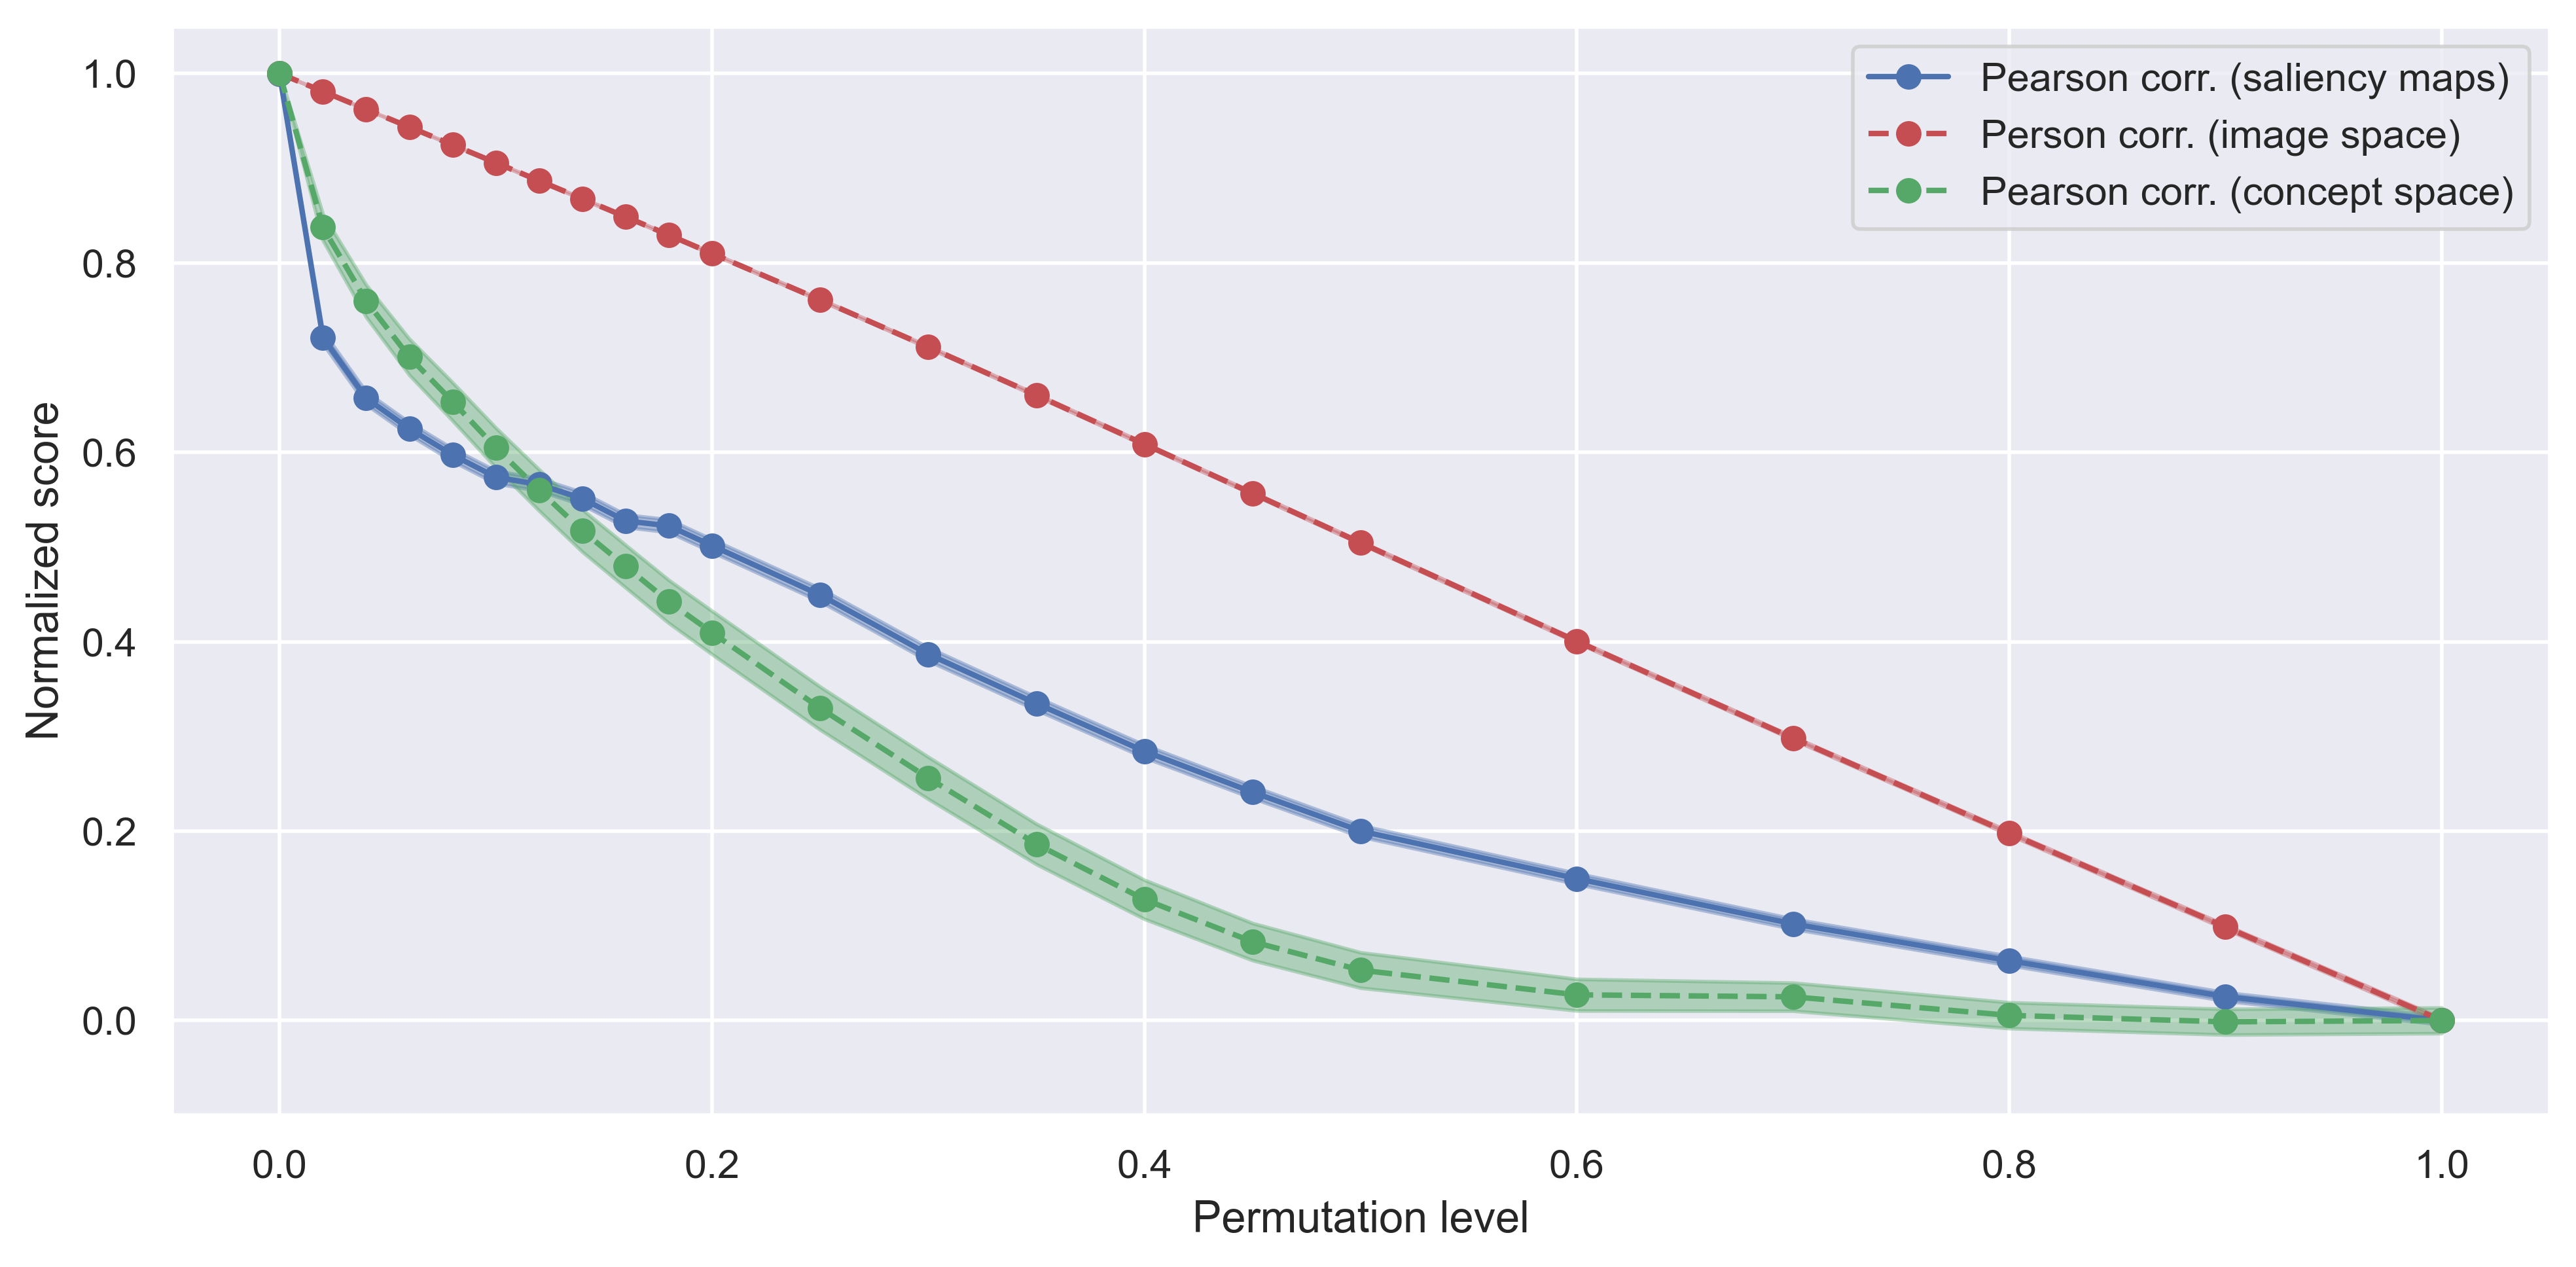

In [46]:
fig = plt.figure(figsize=(10, 5), dpi=400)

# Plot SSIM
plt.fill_between(results_saliency['permutation_level'], results_saliency['normalized_pearson'] - results_saliency['pearson_sem'], results_saliency['normalized_pearson'] + results_saliency['pearson_sem'], color='C0', alpha=0.4)
plt.plot(results_saliency['permutation_level'], results_saliency['normalized_pearson'], 'o-', color='C0', label='Pearson corr. (saliency maps)')
# Plot ssim images
plt.fill_between(results_images['permutation_level'], results_images['normalized_pearson'] - results_images['pearson_sem'], results_images['normalized_pearson'] + results_images['pearson_sem'], color='C3', alpha=0.4)
plt.plot(results_images['permutation_level'], results_images['normalized_pearson'], 'o--', color='C3', label='Person corr. (image space)')
# Plot concept Jaccard
plt.fill_between(results_concepts['permutation_level'], results_concepts['normalized_pearson'] - results_concepts['pearson_sem'], results_concepts['normalized_pearson'] + results_concepts['pearson_sem'], color='C2', alpha=0.4)
plt.plot(results_concepts['permutation_level'], results_concepts['normalized_pearson'], 'o--', color='C2', label='Pearson corr. (concept space)')

plt.ylim([-0.1, 1.05])
plt.xlim([-0.05, 1.05])
plt.ylabel('Normalized score')
plt.xlabel('Permutation level')
plt.legend()
# fig.suptitle("Robustness - Pixel-Flipping")
plt.tight_layout()

### Visualizing some example images

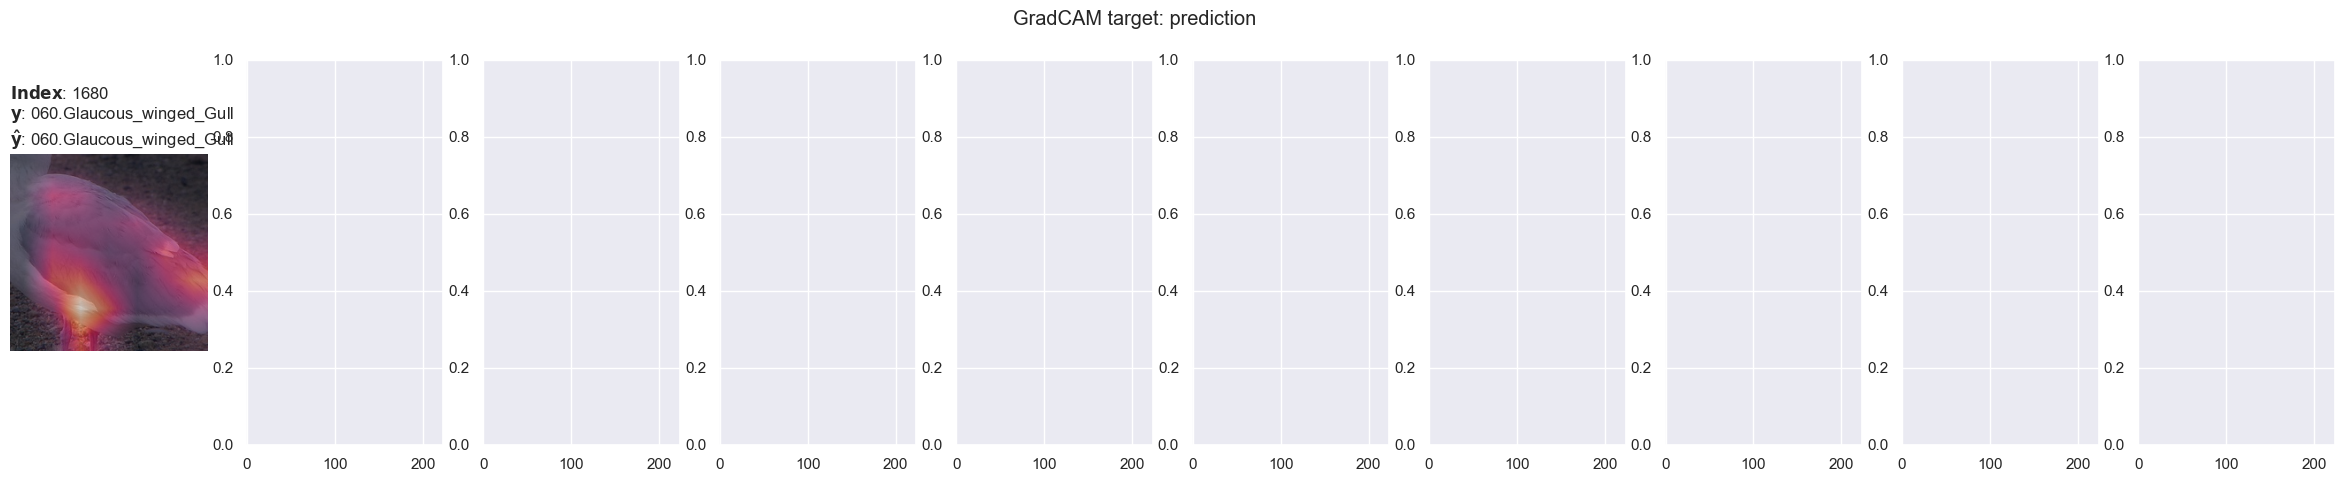

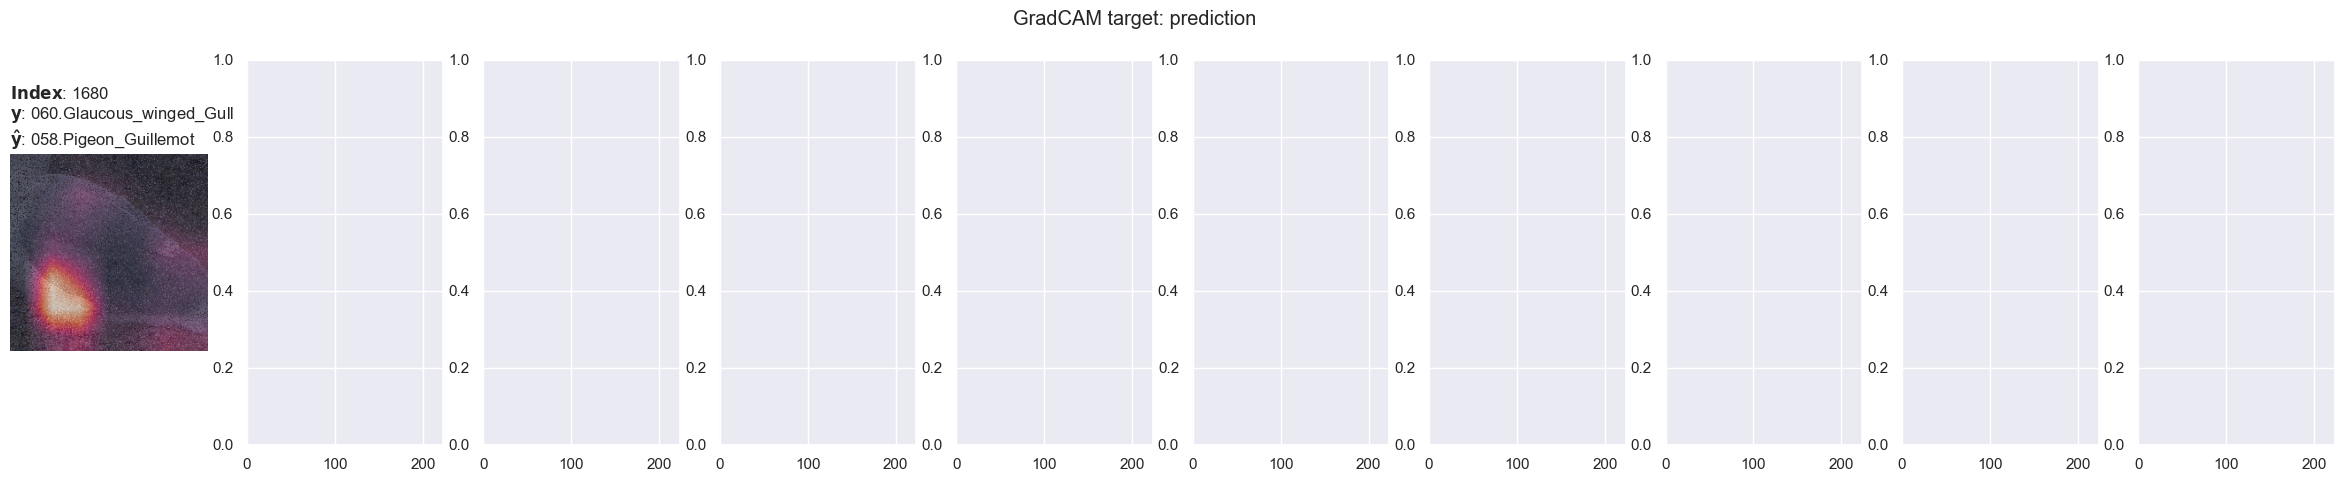

KeyboardInterrupt: 

In [116]:
# Select image index to visualize
np.random.seed(0)
selected_idxs = [564, 2764, 1978, 5590, 556, 2021, 2030, 1655, 5, 2002]

selected_idxs = [1680]

batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

# Compute saliency maps
CAM_target = 'prediction'

pixel_flip_ratios = [0.0, 0.4, 0.6, 0.8, 1.0]

for i, frac in enumerate(pixel_flip_ratios):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)

    # Setup storage
    batch_ = {'index': batch['index'], 'image': [], 'label': batch['label'], 'prediction': [], 'concepts': batch['concepts']}
    for image_idx in range(selected_idxs.__len__()):
        # Get original and target image
        original_image  = batch['image'][image_idx].numpy()
        target_image    = original_image.copy()

        # Do pixel flipping
        for pixel in range(sample_size):
            target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
        
        target_image = torch.tensor(target_image)
        output = model(target_image.unsqueeze(0).to(device))

        batch_['image'].append(target_image)
        batch_['prediction'].append(torch.exp(output).topk(1)[1])

    batch_['image'] = torch.stack(batch_['image'])
    permuted_saliency_maps = compute_saliency_maps(batch_, cam=cam, CAM_target=CAM_target)

    fig = visualize_saliency_maps(permuted_saliency_maps, batch_, normalization, meta=meta, ncols=10, figsize=(30, 5))
    fig.suptitle(f'GradCAM target: {CAM_target}')
    plt.show()